# House Price Prediction with Neural Networks and Hyperparameter Optimization
## By: Dhruv Jayant Verma

In this notebook, we will build a neural network to predict house prices using a customized Boston housing dataset. We will use PyTorch for building the model and Optuna for hyperparameter optimization. The notebook will also include data preprocessing, model training, and evaluation.

## Import Libraries

First, we import the necessary libraries for data manipulation, model building, and evaluation.

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from torch.utils.data import TensorDataset, DataLoader
import warnings

warnings.filterwarnings('ignore')

## Check Device

We check if a GPU is available and set the device accordingly to speed up computations.

In [3]:
if torch.cuda.is_available():
    print("CUDA is available. GPU information:")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. No GPU detected.")

CUDA is available. GPU information:
Number of GPUs: 1
GPU 0: NVIDIA GeForce RTX 4070 Laptop GPU


## Load and Clean Data

Load the Boston housing dataset and perform basic cleaning by removing any missing values.

In [5]:
df = pd.read_csv('BostonHousing.csv')
df = df.dropna()
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Define Features and Target Variables

Select the relevant features and target variable for the prediction task.

In [6]:
X = df[['LSTAT', 'RM', 'TAX', 'INDUS', 'PTRATIO']].values
y = df['MEDV'].values.reshape(-1, 1)  # Ensure y is a column vector

## Data Standardization

Standardize the features and target variable using z-score standardization to ensure they have a mean of 0 and a standard deviation of 1.

In [7]:
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)

## Convert to PyTorch Tensors

Convert the standardized data into PyTorch tensors and move them to the selected device.

In [9]:
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

## Define the Model

Create a function to define the neural network model based on hyperparameters suggested by Optuna.

In [13]:
# Function to define the model based on hyperparameters
def define_model(trial):
    # Suggest hyperparameters for the model
    n_layers = trial.suggest_int('n_layers', 2, 5)
    hidden_size = trial.suggest_int('hidden_size', 32, 256)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    activation_name = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'Tanh', 'ELU'])

    # Select the activation function
    if activation_name == 'ReLU':
        activation = nn.ReLU()
    elif activation_name == 'LeakyReLU':
        activation = nn.LeakyReLU()
    elif activation_name == 'Tanh':
        activation = nn.Tanh()
    elif activation_name == 'ELU':
        activation = nn.ELU()

    # Build the model architecture
    layers = []
    in_features = X.shape[1]
    for _ in range(n_layers):
        layers.append(nn.Linear(in_features, hidden_size))
        layers.append(activation)
        layers.append(nn.Dropout(dropout_rate))
        in_features = hidden_size
    layers.append(nn.Linear(hidden_size, 1))
    model = nn.Sequential(*layers).to(device)
    return model

## Objective Function for Optuna

Define the objective function for Optuna, which includes model training and validation using K-fold cross-validation.

In [11]:
# Define the objective function for Optuna
def objective(trial):
    # Create the model with suggested hyperparameters
    model = define_model(trial)

    # Suggest hyperparameters for optimizer and learning rate
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Implement K-fold cross-validation
    kf = KFold(n_splits=5)
    val_losses = []

    for train_index, val_index in kf.split(X):
        # Split data into training and validation sets
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Create DataLoader for training data
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

        # Training loop
        for epoch in range(50):  # Keep epochs low for faster tuning
            model.train()
            for X_batch, y_batch in train_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            y_pred = model(X_val)
            val_loss = criterion(y_pred, y_val)
            val_losses.append(val_loss.item())

    # Return the average validation loss
    return np.mean(val_losses)

## Hyperparameter Optimization with Optuna

Run the hyperparameter optimization process using Optuna to find the best model configuration.

In [14]:
# Run hyperparameter optimization with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Retrieve the best trial
print('\nNumber of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('Validation Loss (Standardized):', trial.value)
print('\nBest Hyperparameters:', trial.params)

[I 2025-01-31 16:40:32,266] A new study created in memory with name: no-name-29b1cc69-a263-40b3-bdba-78d4422e29cb
[I 2025-01-31 16:40:35,683] Trial 0 finished with value: 0.19625852704048158 and parameters: {'n_layers': 4, 'hidden_size': 157, 'dropout_rate': 0.27270664598732175, 'activation': 'ReLU', 'optimizer': 'RMSprop', 'learning_rate': 0.0007151245676742405, 'batch_size': 64}. Best is trial 0 with value: 0.19625852704048158.
[I 2025-01-31 16:40:45,931] Trial 1 finished with value: 0.4602485567331314 and parameters: {'n_layers': 4, 'hidden_size': 56, 'dropout_rate': 0.30900801284432966, 'activation': 'Tanh', 'optimizer': 'SGD', 'learning_rate': 0.07987675735621382, 'batch_size': 16}. Best is trial 0 with value: 0.19625852704048158.
[I 2025-01-31 16:40:58,673] Trial 2 finished with value: 0.26483705937862395 and parameters: {'n_layers': 5, 'hidden_size': 45, 'dropout_rate': 0.20438215409712593, 'activation': 'Tanh', 'optimizer': 'RMSprop', 'learning_rate': 0.0014148330651692778, 'ba


Number of finished trials: 50
Best trial:
Validation Loss (Standardized): 0.16081214249134063

Best Hyperparameters: {'n_layers': 3, 'hidden_size': 171, 'dropout_rate': 0.10894900240199944, 'activation': 'LeakyReLU', 'optimizer': 'Adam', 'learning_rate': 0.0010669234514020238, 'batch_size': 16}


## Build and Train the Final Model

Use the best hyperparameters to build and train the final model, including early stopping and learning rate scheduling.

In [15]:
# Use the best hyperparameters to build the final model
best_params = trial.params
model = define_model(trial)
optimizer_name = best_params['optimizer']
learning_rate = best_params['learning_rate']
batch_size = best_params['batch_size']

# Define loss function and optimizer
criterion = nn.MSELoss()
if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_name == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
elif optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Define the Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Create DataLoader with the best batch size
train_dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Initialize lists to store loss values
train_losses = []
val_losses = []
learning_rates = []

# Training loop with Early Stopping
num_epochs = 100
best_loss = None
epochs_no_improve = 0
patience = 10
early_stop = False

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Calculate average training loss over an epoch
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()
    with torch.no_grad():
        y_pred = model(X)
        val_loss = criterion(y_pred, y)
    val_loss_value = val_loss.item()
    val_losses.append(val_loss_value)

    # Step the scheduler
    scheduler.step(val_loss_value)
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Early Stopping logic
    if best_loss is None:
        best_loss = val_loss_value
    elif val_loss_value < best_loss - 1e-4:
        best_loss = val_loss_value
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print('Early stopping!')
        early_stop = True

    # Print progress
    if (epoch + 1) % 10 == 0 or early_stop:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss_value:.4f}')
    if early_stop:
        break

# Load the best model state if saved
if 'best_model_state' in locals():
    model.load_state_dict(best_model_state)

Epoch [10/100], Train Loss: 0.1597, Validation Loss: 0.1280
Epoch [20/100], Train Loss: 0.1313, Validation Loss: 0.1107
Epoch [30/100], Train Loss: 0.1298, Validation Loss: 0.1025
Epoch [40/100], Train Loss: 0.1109, Validation Loss: 0.0926
Epoch [50/100], Train Loss: 0.1068, Validation Loss: 0.0895
Epoch [60/100], Train Loss: 0.0997, Validation Loss: 0.0803
Epoch [70/100], Train Loss: 0.0980, Validation Loss: 0.0774
Epoch [80/100], Train Loss: 0.0954, Validation Loss: 0.0754
Epoch [90/100], Train Loss: 0.0907, Validation Loss: 0.0741
Epoch [100/100], Train Loss: 0.0837, Validation Loss: 0.0732


## Visualize Training and Validation Loss

Plot the training and validation loss over epochs to visualize the model's learning process.

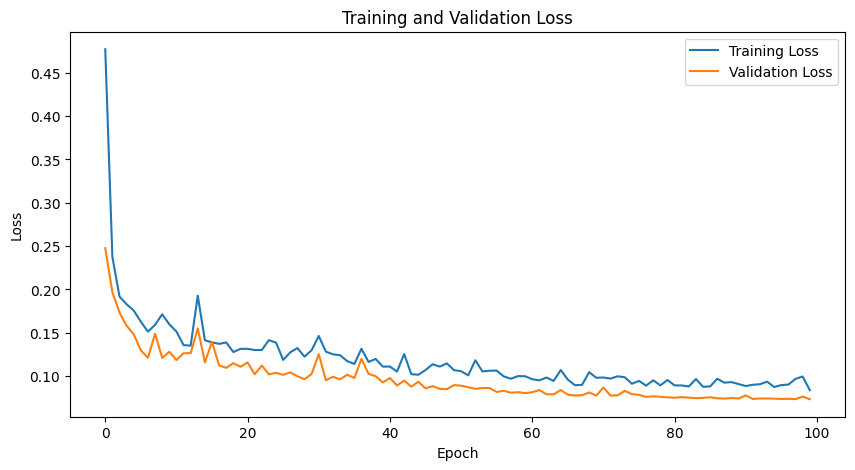

In [18]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Visualize Learning Rate Over Epochs

Plot the learning rate over epochs to understand how it changes during training.

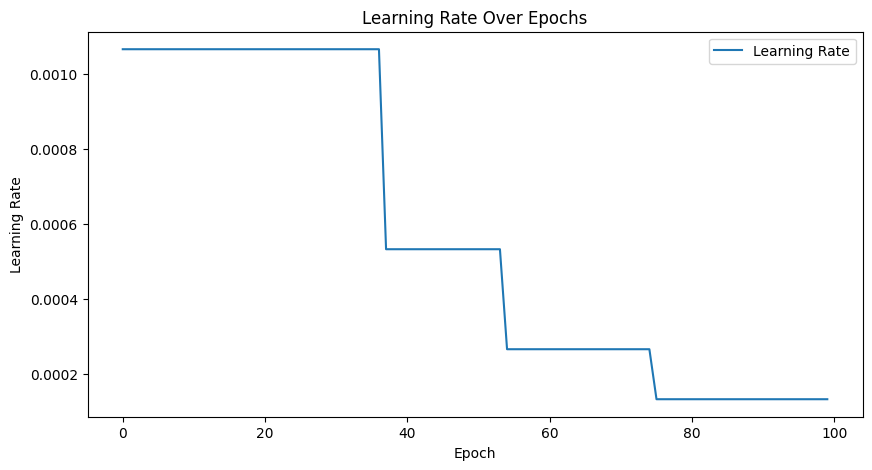

In [19]:
# Plot learning rate over epochs
plt.figure(figsize=(10, 5))
plt.plot(learning_rates, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Over Epochs')
plt.legend()
plt.show()

## Evaluate the Model

Perform a final evaluation of the model on the test data and calculate performance metrics.

In [20]:
# Final evaluation on test data
model.eval()
with torch.no_grad():
    y_pred = model(X)
    test_loss = criterion(y_pred, y)
    print(f'\nFinal Test Loss (Standardized): {test_loss.item():.4f}')

# Inverse transform the predictions and actual values to original scale
y_pred_inv = scaler_y.inverse_transform(y_pred.cpu().numpy())
y_inv = scaler_y.inverse_transform(y.cpu().numpy())

# Calculate performance metrics on original scale
mae = mean_absolute_error(y_inv, y_pred_inv)
r2 = r2_score(y_inv, y_pred_inv)
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared Score: {r2:.4f}')
print('Best Hyperparameters:', best_params)


Final Test Loss (Standardized): 0.0732
Mean Absolute Error: 1.7234
R-squared Score: 0.9268
Best Hyperparameters: {'n_layers': 3, 'hidden_size': 171, 'dropout_rate': 0.10894900240199944, 'activation': 'LeakyReLU', 'optimizer': 'Adam', 'learning_rate': 0.0010669234514020238, 'batch_size': 16}


## Visualize Predictions vs Actual Values

Plot the predicted vs actual values to assess the model's performance visually.

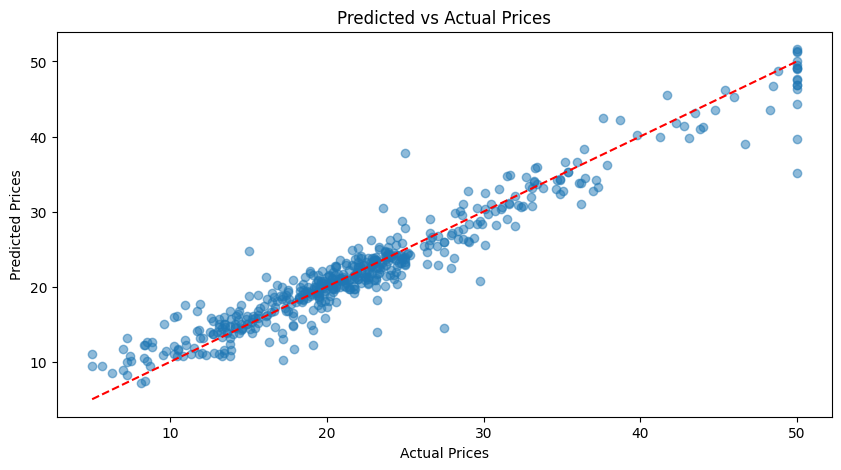

In [21]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 5))
plt.scatter(y_inv, y_pred_inv, alpha=0.5)
plt.plot([y_inv.min(), y_inv.max()], [y_inv.min(), y_inv.max()], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices')
plt.show()